In [1]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import random
import time



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#User input for algorithm:
#for synthetic data/potentially for regular datasets user can set the total subgroups/centroids
centroids = input("Enter number of centroids: ")
groups = input("Enter number of groups: ")

Enter number of centroids: 10
Enter number of groups: 5


In [3]:
#calculates euclidean distance between points
def calc_dist(x,y,x_ref,y_ref):
  return np.sqrt((((x-x_ref)**2)+((y-y_ref)**2))) 


In [4]:
#calculuates loss by inputting euclidean distance into sigmoid function
def calc_loss(x,y,x_ref,y_ref):
    # calculate Euclidean distance btw person & centroid
    distance = calc_dist(x,y,x_ref,y_ref)
    # refer to the above distance function to determine individual loss
    loss = 1/(1+ np.exp(-1*(distance))) #converts distances to probability distribution
    #return loss
    return loss

In [5]:
#this function calculates the summation of all the individual losses within each cluster for minimizing the objective function
def sum_loss(df, centroids, subgroup_loss):
  #total datapoints
  tot_len = 0
  #sum of all individual losses between clusters
  loss_sum = 0
  clusters = []
  max_val = df['min_loss'].max()
  min_val = df['min_loss'].min()

  for i in centroids.keys():
    temp = df[df['min_centr']==i]
    temp = temp.reset_index()
    clusters.append(temp)
    tot_len += len(temp)
    loss_sum += temp['min_loss'].sum()
  # print('indiv loss ', (loss_sum/tot_len))
  # print('subgroup loss: ', subgroup_loss)
  tot_loss = .8*(loss_sum/tot_len)
  tot_loss += ((1-.8)*subgroup_loss)
  print('indiv loss ', tot_loss)
  print('subgroup loss: ', subgroup_loss)
  return .1*tot_loss


In [6]:
def assign_cluster(df, centroids):
  start = time.time()
  for i in centroids.keys():
    #loss based on euclidean distance for each individual point compared to both centroids
    #stored in dataframe
    df['loss_from_{}'.format(i)] = calc_loss(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])
    df['dist_from_{}'.format(i)] = calc_dist(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])
  centroid_dist_col = ['loss_from_{}'.format(i) for i in centroids.keys()]
  #df column which holds the value of the closest centroid for each point
  df['min_centr'] = df.loc[:, centroid_dist_col].idxmin(axis=1)
  df['min_centr'] = df['min_centr'].map(lambda x: int(x.lstrip('loss_from_')))
  #value of loss calculated from sigmoid in calc_loss function for individual loss
  df['min_loss'] = df[['loss_from_{}'.format(i) for i in centroids.keys()]].min(axis=1)
  end = time.time()
  print('Time elapsed Assignment Step: ', end - start)
  for i in range(len(centroids)):
    del df['loss_from_{}'.format(i)]
    lst = df['min_centr'].unique()
    if i not in lst:
      del df['dist_from_{}'.format(i)]
  return df

In [7]:
# this function compares the loss between two groups at a certain percentile level
def compare_loss(group1,group2,percentile):
    select_group = [group1, group2]
    percentile_loss = []
    for s in select_group:
        s.sort_values(by=['min_loss'])
        subgroup = [s['min_loss']] # subset the two different groups of interest
        loss_p = stats.scoreatpercentile(subgroup, percentile) # find the level of loss at given percentile
        percentile_loss.append(loss_p) # load list with loss    
    difference = percentile_loss[0]-percentile_loss[1] # find difference between two @ percentile
    return np.abs(difference)

In [8]:
#calculates gradient for clusters
def update_weights(clust, lr, centr, df):
  #total number of points in cluster 0 (points nearest to centroid 0)
  new_centr_x, new_centr_y = centr[0], centr[1]
  #calculate partial derivatives of euclidean distance functions
  x = clust['x_coord']
  y = clust['y_coord']
  center = clust['min_centr']
  distance = clust['dist_from_{}'.format(int(center))]
  grad_x = (np.exp(-1*distance) * (x - centr[0])) / (1 + np.exp(-1*distance)*distance)
  grad_y = (np.exp(-1*distance) * (y - centr[1])) / (1 + np.exp(-1*distance)*distance)
  # new_centr_x += (grad_x) * lr
  # new_centr_y += (grad_y) * lr
  # print('new loss: *** ', calc_loss(x,y,new_centr_x, new_centr_y))
  new_centr_x = (grad_x) 
  new_centr_y = (grad_y) 
  return (new_centr_x, new_centr_y)

In [9]:
import random
def mini_batch(df, b, count, temp_centroids, centroids, groups, cdf1,cdf2):
  # samp = groups[cdf1].sample(n=b, random_state=1)
  weight1 = random.uniform(0,.5)
  weight2 = 1-weight1
  print('w1 ', weight1, ' w2 ', weight2)
  samp1 = groups[cdf1].sample(n=int(b*weight2), random_state=1)
  samp2 = groups[cdf2].sample(n=int(b*weight1), random_state=1)
  samp = pd.concat([samp1, samp2], ignore_index=True, sort=False)
  samp = samp.reset_index()
  # s = []
  # for i in len(groups):
  #   weight = random.uniform(0,1)
  #   temp_s = groups[i].sample(n=int(b*weight), random_state=1)
  #   s.append(temp_s)
  # samp = pd.concat([samp for samp in s], ignore_index=True, sort=False)
  start = time.time()
  sum_x = {}
  for i in centroids.keys():
    sum_x[i] = 0
  sum_y = {}
  for i in centroids.keys():
    sum_y[i] = 0
  for i in centroids.keys():
    count[i] = 0
  for s in range(len(samp)):
    clust = samp.iloc[s]['min_centr']
    clust = int(clust)
    count[clust]+=1
    lr = 1/count[clust]
    temp = update_weights(samp.iloc[s], lr, temp_centroids[clust], df)
    sum_x[clust] += temp[0]
    sum_y[clust] += temp[1]
  for i in range(len(temp_centroids)):
    if count[i]!= 0:
      temp_centroids[i] = (temp_centroids[i][0]-lr*(sum_x[i]/count[i]), temp_centroids[i][1]-lr*(sum_y[i]/count[i]))
  end = time.time()
  print('Time elapsed Batch Step: ', end - start)
  return temp_centroids

In [10]:
#updates centroid locations based on gradient descent and loss constraint
def update(perc, centroids, df, subgroup_loss, loss, groups, cdf1, cdf2):
  tot_loss_lst = []
  prev_centr = {}
  for i in centroids.keys():
    prev_centr[i] = 0

  b = 1000
  max_iter = 150
  iter_num = 0
  conv = 10
  j = 0
  tot_loss_lst.append(loss)
  #set temporary centroids for assignment
  temp_centroids = {}
  for i in centroids.keys():
    temp_centroids[i] = centroids[i]
  count = {}
  #beginning of updating 
  while iter_num < max_iter:
    start = time.time()
    old_loss = loss
    #set up for mini batch gradient descent
    temp_centroids = mini_batch(df, b, count, temp_centroids, centroids, groups, cdf1, cdf2)
    #testing to see if new centroid locations improve summation of individual loss
    temp_df = assign_cluster(df, temp_centroids)
    groups = compute_groups(temp_df)
    cdf1, cdf2 = compute_cdf(groups)
    temp_subgroup_loss = compare_loss(groups[cdf1], groups[cdf2], 50)   
    temp_loss = sum_loss(temp_df, temp_centroids, temp_subgroup_loss)
    iter_num += 1
    print('iteration number: ', iter_num)
    print('old loss: ', old_loss)
    print('temp loss: ', temp_loss)
    if old_loss != temp_loss and j < conv:
      #only change centroid locations if it improves subgroup loss
      if old_loss > temp_loss:
        subgroup_loss = temp_subgroup_loss
        loss = temp_loss
        df = temp_df
        groups = compute_groups(df)
        compute_cdf_graph(groups)
        for i in prev_centr.keys():
          prev_centr[i] = centroids[i]
        for i in centroids.keys():
          centroids[i] = temp_centroids[i]
        print('c ', centroids)
        fig = plt.figure(figsize=(5,5))
        ax = sns.scatterplot(X[:,0],X[:,1],hue=y)

        for i in centroids.keys():
          plt.scatter(centroids[i][0], centroids[i][1], color=color_map[i])

        plt.xlim(-25, 25)
        plt.ylim(-25, 25)
        ax.set_title("Synthetic Data")
        plt.show()
      else:
        j += 1
      # loss = sum_loss(temp_df, centroids, subgroup_loss)
      tot_loss_lst.append(loss)
    else:
      end = time.time()
      print('Time elapsed End of Update Step: ', end - start)
      plt.title('Cost per iteration')
      plt.plot(tot_loss_lst)
      plt.show()
      return centroids
  plt.title('Cost per iteration')
  plt.plot(tot_loss_lst)
  plt.show()
  print('Reached max iterations')
  print('prev centroids: ', prev_centr)
  return centroids    

In [11]:
def compute_cdf(groups):
  lst = []
  perc = []
  for group in groups:
    sorted_data = group.sort_values(by=['min_loss'])
    sorted_len = len(sorted_data['min_loss'])
    yvals = np.arange(sorted_len)/float(sorted_len-1)
    lst.append(sorted_data['min_loss'].sum())
    subgroup = [sorted_data['min_loss']] # subset the two different groups of interest
    perc.append(stats.scoreatpercentile(subgroup, 50))
  min_ind = perc.index(min(perc))
  max_ind = perc.index(max(perc))
  return (max_ind, min_ind)

In [12]:
def compute_cdf_graph(groups):
  for group in groups:
    sorted_data = group.sort_values(by=['min_loss'])
    sorted_len = len(sorted_data['min_loss'])
    yvals = np.arange(sorted_len)/float(sorted_len-1)
    subgroup = [sorted_data['min_loss']] # subset the two different groups of interest
    plt.plot(sorted_data['min_loss'], yvals)
  plt.xlabel('loss per individual')
  plt.ylabel('% of people within certain loss of centroid')
  plt.title('Individual loss- CDF stratified by group')
  plt.show()

In [13]:
def compute_groups(df):
  num_groups = df.group.nunique()
  groups = []
  for i in range(num_groups):
    group = df[df['group']==i]
    group = group.reset_index()
    groups.append(group)
  return groups

In [14]:
def compute_clusters(df):
  num_clusters = df.min_centr.nunique()
  clusters = []
  for i in range(num_clusters):
    cluster = df[df['min_centr']==i]
    cluster = cluster.reset_index()
    clusters.append(cluster)
  return clusters

Time elapsed Assignment Step:  2.345391035079956


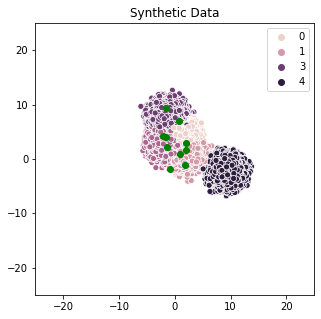

{0: (-1.5115294009373355, 9.405737363222864),
 1: (-1.6372574281045003, 4.0128424834205205),
 2: (-2.0113853467597202, 4.1462168575450296),
 3: (2.0930495740737967, 1.6927684969741814),
 4: (1.9602611312663, 2.9821936267696163),
 5: (-1.3631621320843135, 2.1070289793754),
 6: (1.7688028629639603, -1.1237780128104167),
 7: (-0.8211857258204025, -1.8743669238562986),
 8: (0.9311567748531603, 0.8474713955189381),
 9: (0.8246172860587468, 6.9024434503575165)}

In [15]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
import random

# Generate Imbalanced Synthetic Data
# X,y = make_classification(n_samples=800000, n_classes=2,shift=4 ,n_informative=4, n_redundant=0,n_repeated=0, n_clusters_per_class=2,class_sep=.8,flip_y=0,weights=[0.85,.15], random_state=55)
X, y = make_blobs(n_samples=800000, centers=int(groups), n_features=2, random_state=0)
# create dataframe to hold x and y coordinates
df = pd.DataFrame({
    'x_coord': X[:,0],
    'y_coord': X[:,1]})
df['group'] = y

 
#arbitrarily picked random k (number of centroids)
k = int(centroids)
centroids = {}
#randomly initialized centroid x and y coordinates (in real data we will actually have these coordinates)
for i in range(k):
  centroids[i] = ((random.choice(X[:,0])), (random.choice(X[:,1])))
  # centroids[i] = (-10,-10)

#colors for centroids
color_map = {}
for i in range(k):
  color_map[i] = 'g'

#plot synthetic data
fig = plt.figure(figsize=(5,5))
ax = sns.scatterplot(X[:,0],X[:,1],hue=y)

for i in centroids.keys():
  plt.scatter(centroids[i][0], centroids[i][1], color=color_map[i])
df = assign_cluster(df, centroids)
df
plt.xlim(-25, 25)
plt.ylim(-25, 25)
ax.set_title("Synthetic Data")
plt.show()

centroids

Time elapsed Assignment Step:  2.3576793670654297


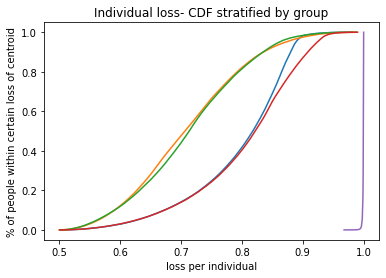

indiv loss  0.7024133662726986
subgroup loss:  0.29312760527334236
w1  0.1728793445242176  w2  0.8271206554757824
Time elapsed Batch Step:  0.4318046569824219
Time elapsed Assignment Step:  2.3045589923858643
indiv loss  0.7024118400720699
subgroup loss:  0.2931214784746732
iteration number:  1
old loss:  0.07024133662726986
temp loss:  0.070241184007207


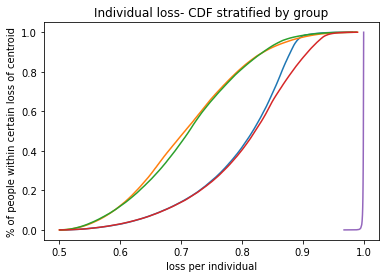

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0929823387510984, 1.6928565419707233), 4: (1.9602383514815962, 2.9823071314101477), 5: (-1.3634734246166402, 2.107051396705354), 6: (1.7687907237282674, -1.1237846980737634), 7: (-0.8214255051799302, -1.8745730563323029), 8: (0.9310542437616189, 0.8474731397311955), 9: (0.8246172860587468, 6.9024434503575165)}


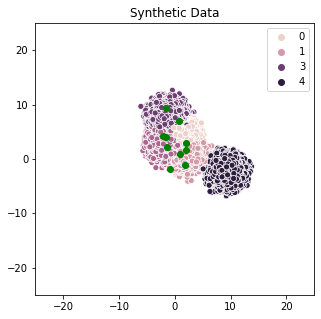

w1  0.326951284324126  w2  0.673048715675874
Time elapsed Batch Step:  0.4109189510345459
Time elapsed Assignment Step:  2.3056671619415283
indiv loss  0.7024037346370967
subgroup loss:  0.29308250898325183
iteration number:  2
old loss:  0.070241184007207
temp loss:  0.07024037346370968


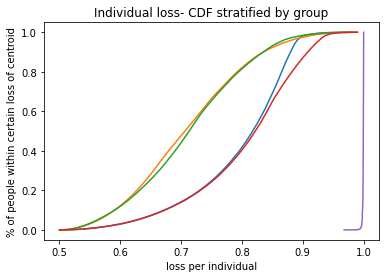

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0926147056274655, 1.6933190689015207), 4: (1.9600273148021994, 2.9827065952793057), 5: (-1.3649814215256193, 2.107068141624713), 6: (1.7687053798457297, -1.1238533954490526), 7: (-0.8225813819716628, -1.8755667354609202), 8: (0.9306773217077116, 0.8475043092991391), 9: (0.8246172860587468, 6.9024434503575165)}


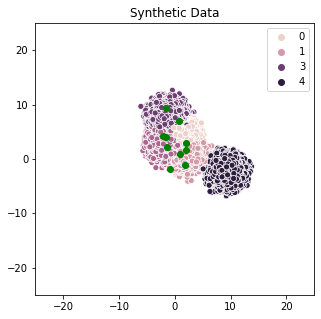

w1  0.0785947266139132  w2  0.9214052733860868
Time elapsed Batch Step:  0.4162607192993164
Time elapsed Assignment Step:  2.3122260570526123
indiv loss  0.7023434416855798
subgroup loss:  0.29279872171000754
iteration number:  3
old loss:  0.07024037346370968
temp loss:  0.07023434416855799


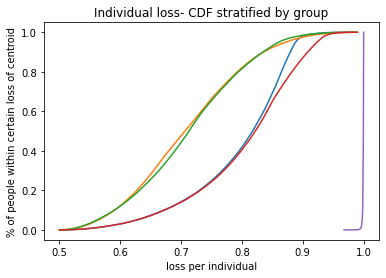

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.089817953983129, 1.6956686788149207), 4: (1.9633828033563965, 2.989804114021778), 5: (-1.3789944027320962, 2.105630043937906), 6: (1.768298511622666, -1.123929989635858), 7: (-0.833688144254114, -1.8851149485105498), 8: (0.9256612504862467, 0.8483784670904781), 9: (0.8246172860587468, 6.9024434503575165)}


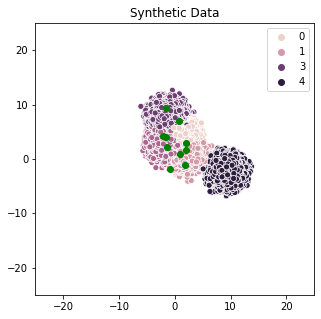

w1  0.1502597543084574  w2  0.8497402456915426
Time elapsed Batch Step:  0.4145057201385498
Time elapsed Assignment Step:  2.3329198360443115
indiv loss  0.7023285927923022
subgroup loss:  0.2927284693686186
iteration number:  4
old loss:  0.07023434416855799
temp loss:  0.07023285927923022


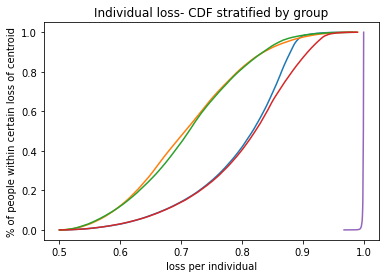

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0892265703692217, 1.6964087307396494), 4: (1.9633266450888818, 2.990779063262241), 5: (-1.3817489991162573, 2.1056901608865304), 6: (1.76819302005507, -1.1239814687743273), 7: (-0.8358330792525898, -1.8869588968928261), 8: (0.9246029389347146, 0.8485097968239621), 9: (0.8246172860587468, 6.9024434503575165)}


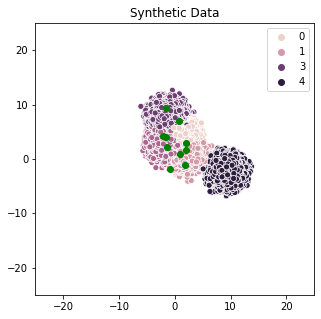

w1  0.49285280741976134  w2  0.5071471925802387
Time elapsed Batch Step:  0.41171717643737793
Time elapsed Assignment Step:  2.3894705772399902
indiv loss  0.7023150591736358
subgroup loss:  0.2926591795928387
iteration number:  5
old loss:  0.07023285927923022
temp loss:  0.07023150591736359


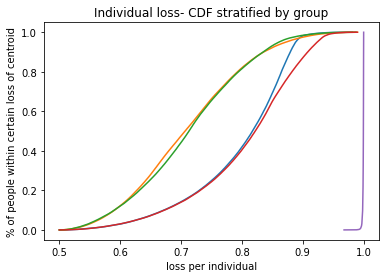

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.088683378690058, 1.6970837409063266), 4: (1.9629262473767826, 2.991328503911099), 5: (-1.3839194620892086, 2.10560390216773), 6: (1.768004994273061, -1.1241626318438287), 7: (-0.837494672919907, -1.888387328503587), 8: (0.9240459318857432, 0.8486921945113819), 9: (0.8246172860587468, 6.9024434503575165)}


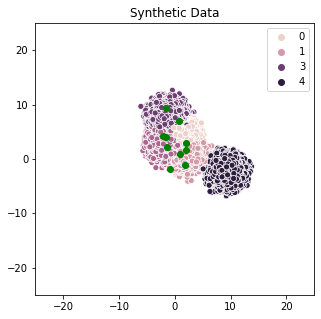

w1  0.4159916738357789  w2  0.584008326164221
Time elapsed Batch Step:  0.4095194339752197
Time elapsed Assignment Step:  2.335707426071167
indiv loss  0.7023092595085613
subgroup loss:  0.29262815712555
iteration number:  6
old loss:  0.07023150591736359
temp loss:  0.07023092595085613


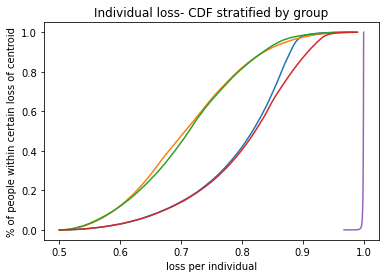

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.08839742238627, 1.6974534468863265), 4: (1.9627738223184672, 2.9916377306602304), 5: (-1.3851195354232804, 2.1055562118733304), 6: (1.7679232551798665, -1.1242406848357658), 7: (-0.8384132111962078, -1.889176973490427), 8: (0.9237285431141575, 0.8488540189305538), 9: (0.8246172860587468, 6.9024434503575165)}


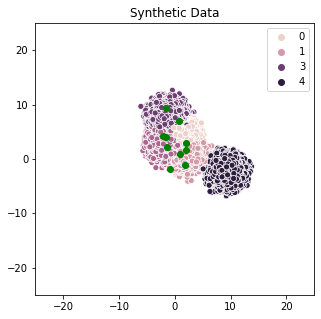

w1  0.31589830545879893  w2  0.6841016945412011
Time elapsed Batch Step:  0.4498255252838135
Time elapsed Assignment Step:  2.308371067047119
indiv loss  0.7023025466366977
subgroup loss:  0.29259327953530345
iteration number:  7
old loss:  0.07023092595085613
temp loss:  0.07023025466366976


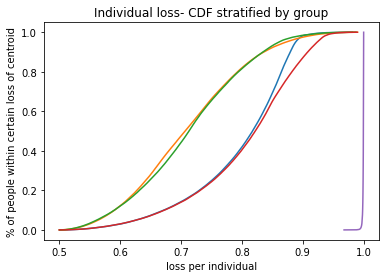

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.088024307373375, 1.697917887768473), 4: (1.9625937271985068, 2.9920206632894275), 5: (-1.3866608535757106, 2.1055710580980924), 6: (1.7678357208870055, -1.1243061509681123), 7: (-0.8395924111617361, -1.8901907029835636), 8: (0.9233192044877996, 0.8488735181551494), 9: (0.8246172860587468, 6.9024434503575165)}


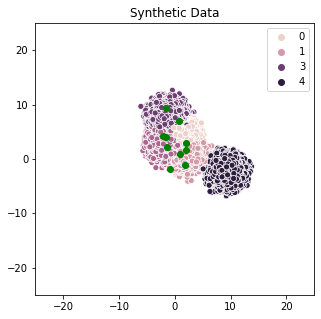

w1  0.3670824767637009  w2  0.6329175232362991
Time elapsed Batch Step:  0.4210846424102783
Time elapsed Assignment Step:  2.2899439334869385
indiv loss  0.7022969819548401
subgroup loss:  0.2925636329118909
iteration number:  8
old loss:  0.07023025466366976
temp loss:  0.07022969819548401


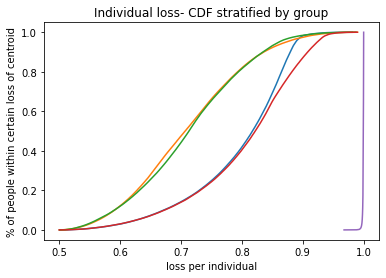

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0877338183344696, 1.6983205778625974), 4: (1.9624106356921676, 2.9923309746603124), 5: (-1.387949791815057, 2.1055199245707565), 6: (1.7677562857677331, -1.1243745416339699), 7: (-0.8405787270385741, -1.8910386147229874), 8: (0.9229855695543501, 0.8489286466710279), 9: (0.8246172860587468, 6.9024434503575165)}


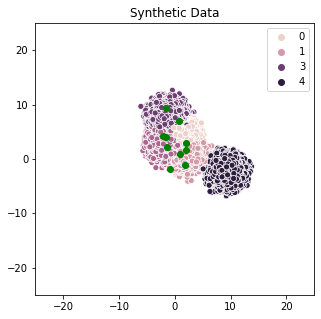

w1  0.3870775188185012  w2  0.6129224811814988
Time elapsed Batch Step:  0.4783802032470703
Time elapsed Assignment Step:  2.4368443489074707
indiv loss  0.7022928588067724
subgroup loss:  0.2925414711199299
iteration number:  9
old loss:  0.07022969819548401
temp loss:  0.07022928588067724


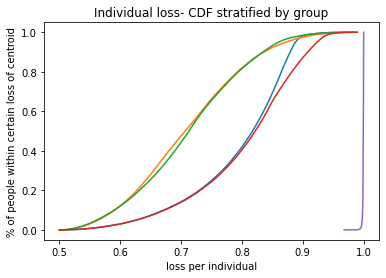

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.087446533428712, 1.69870673658761), 4: (1.9622525878920398, 2.9926517614687915), 5: (-1.389189511184096, 2.1054707454973265), 6: (1.7676766930960255, -1.1244468244432895), 7: (-0.841527273089961, -1.891854056663285), 8: (0.9226962706183064, 0.8490464248081179), 9: (0.8246172860587468, 6.9024434503575165)}


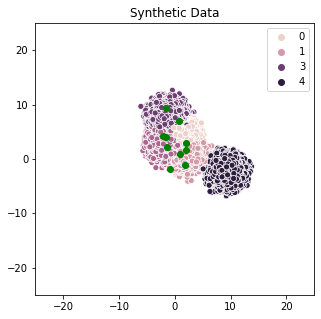

w1  0.4087732501676435  w2  0.5912267498323565
Time elapsed Batch Step:  0.44435667991638184
Time elapsed Assignment Step:  2.331885814666748
indiv loss  0.7022919777394974
subgroup loss:  0.2925364073530088
iteration number:  10
old loss:  0.07022928588067724
temp loss:  0.07022919777394974


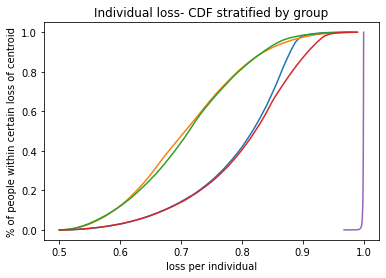

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0873540619802657, 1.6988337292095228), 4: (1.9622010762098336, 2.992756334006429), 5: (-1.3895931038927871, 2.1054547357575375), 6: (1.7676496945903475, -1.1244724142227152), 7: (-0.8418360404864538, -1.8921194964745927), 8: (0.9225929124420158, 0.8491001131636042), 9: (0.8246172860587468, 6.9024434503575165)}


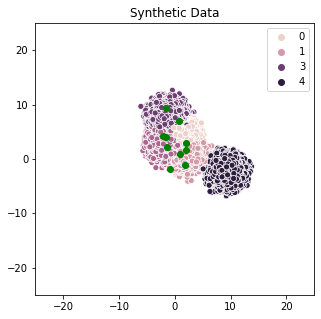

w1  0.238239548521822  w2  0.761760451478178
Time elapsed Batch Step:  0.4423344135284424
Time elapsed Assignment Step:  2.3074190616607666
indiv loss  0.7022697370220986
subgroup loss:  0.2924230811629298
iteration number:  11
old loss:  0.07022919777394974
temp loss:  0.07022697370220986


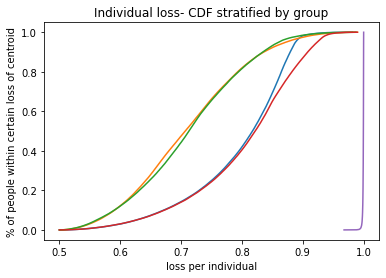

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.086271370551448, 1.7001653443032598), 4: (1.962300147739082, 2.994216030967558), 5: (-1.3941335383588598, 2.1057687262795084), 6: (1.7674386636660808, -1.1246182810688452), 7: (-0.8453297601069996, -1.8951229621493149), 8: (0.9215103153717917, 0.8489378136777455), 9: (0.8246172860587468, 6.9024434503575165)}


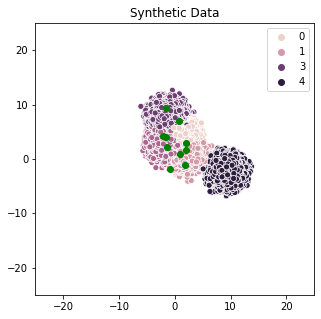

w1  0.14199018083310466  w2  0.8580098191668953
Time elapsed Batch Step:  0.42076587677001953
Time elapsed Assignment Step:  2.3016815185546875
indiv loss  0.7022259775429763
subgroup loss:  0.29223411661958765
iteration number:  12
old loss:  0.07022697370220986
temp loss:  0.07022259775429764


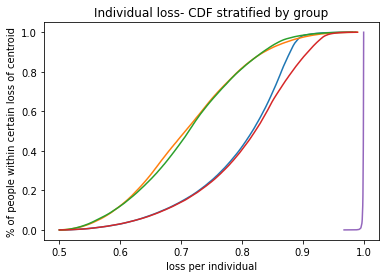

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0847143339692065, 1.7023164613135542), 4: (1.9615717974807831, 2.997082040160286), 5: (-1.4021168976220024, 2.105941649100343), 6: (1.767143991486703, -1.1247536135748923), 7: (-0.8515483370310148, -1.9004689212889845), 8: (0.9186976105235382, 0.8495156914847936), 9: (0.8246172860587468, 6.9024434503575165)}


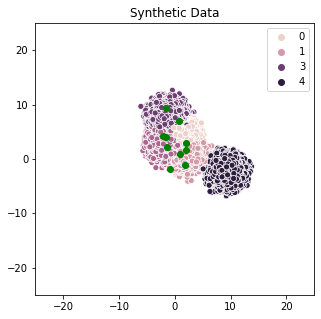

w1  0.18873389585187894  w2  0.8112661041481211
Time elapsed Batch Step:  0.43992018699645996
Time elapsed Assignment Step:  2.319586753845215
indiv loss  0.7021544867622368
subgroup loss:  0.2918804349903038
iteration number:  13
old loss:  0.07022259775429764
temp loss:  0.07021544867622369


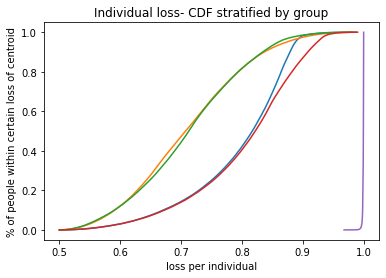

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.081545983678541, 1.706313241182963), 4: (1.9615501627070457, 3.0019176356453516), 5: (-1.4164705471619485, 2.1069294074524483), 6: (1.7665575243025122, -1.1250622179767982), 7: (-0.8625887433060341, -1.9099600896950024), 8: (0.9138914513518427, 0.8493251859349368), 9: (0.8246172860587468, 6.9024434503575165)}


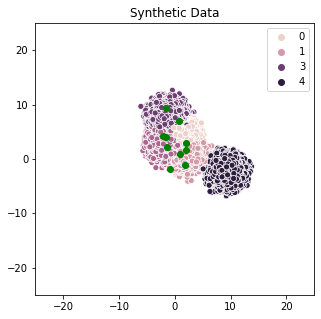

w1  0.4873171017943358  w2  0.5126828982056642
Time elapsed Batch Step:  0.42104578018188477
Time elapsed Assignment Step:  2.3456032276153564
indiv loss  0.7021524094381926
subgroup loss:  0.2918694946646786
iteration number:  14
old loss:  0.07021544867622369
temp loss:  0.07021524094381926


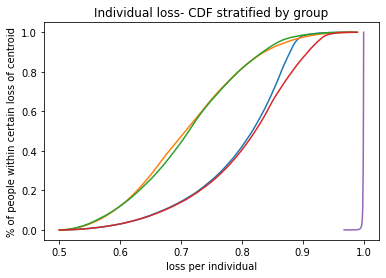

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0814328328715126, 1.7064513324381556), 4: (1.961467306386695, 3.0020358922723713), 5: (-1.4169153386727282, 2.1069127209931953), 6: (1.7665191135186051, -1.1250991318452193), 7: (-0.8629281937315402, -1.9102519069591246), 8: (0.9137759151959696, 0.8493643936745737), 9: (0.8246172860587468, 6.9024434503575165)}


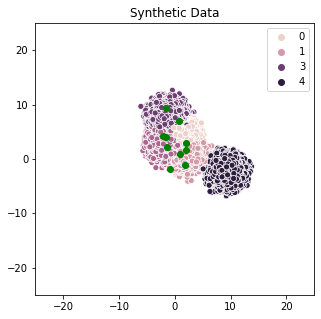

w1  0.4875187592856437  w2  0.5124812407143563
Time elapsed Batch Step:  0.4181830883026123
Time elapsed Assignment Step:  2.3451638221740723
indiv loss  0.7021497062735714
subgroup loss:  0.29185543499510624
iteration number:  15
old loss:  0.07021524094381926
temp loss:  0.07021497062735714


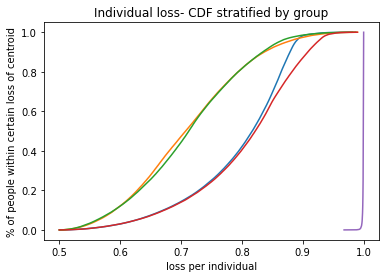

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0813196078245992, 1.706588053805086), 4: (1.96138456213697, 3.0021540028662574), 5: (-1.4173593520088703, 2.106896063943066), 6: (1.766480583661555, -1.1251366163538044), 7: (-0.863267037761018, -1.9105432029193488), 8: (0.9136605317237094, 0.8494035438584376), 9: (0.8246172860587468, 6.9024434503575165)}


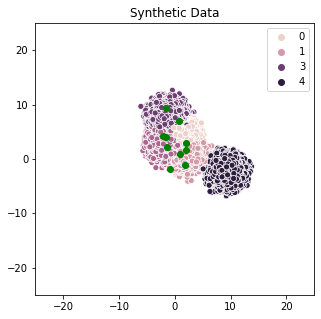

w1  0.2897695004287706  w2  0.7102304995712294
Time elapsed Batch Step:  0.4258456230163574
Time elapsed Assignment Step:  2.3994970321655273
indiv loss  0.7021486186842782
subgroup loss:  0.2918495952748956
iteration number:  16
old loss:  0.07021497062735714
temp loss:  0.07021486186842783


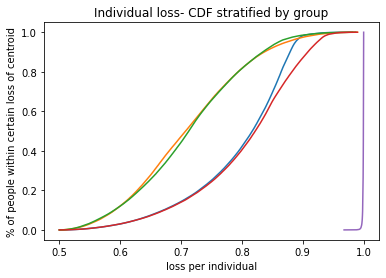

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0812417275008688, 1.706692698781466), 4: (1.9613606392008223, 3.0022548654945855), 5: (-1.4177089393923512, 2.106899739241635), 6: (1.7664625620464798, -1.125150298855283), 7: (-0.8635338055630069, -1.9107725367020836), 8: (0.9135678952446379, 0.8494034286638901), 9: (0.8246172860587468, 6.9024434503575165)}


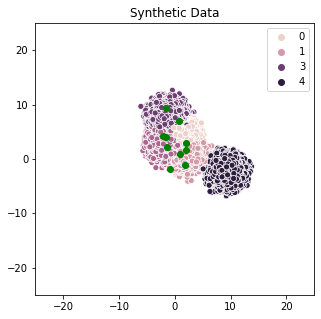

w1  0.3304548003335428  w2  0.6695451996664572
Time elapsed Batch Step:  0.43216943740844727
Time elapsed Assignment Step:  2.3143973350524902
indiv loss  0.7021405395182345
subgroup loss:  0.2918084007495523
iteration number:  17
old loss:  0.07021486186842783
temp loss:  0.07021405395182345


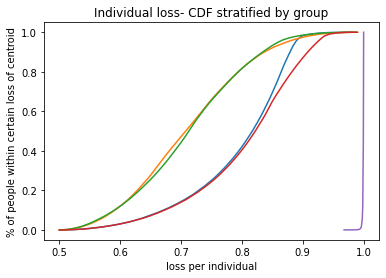

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.080884125994544, 1.7071350096405753), 4: (1.9611470250036402, 3.002641658118301), 5: (-1.4191763664235795, 2.106915167010672), 6: (1.7663783261436763, -1.1252197330001934), 7: (-0.8646535594346956, -1.9117351618360459), 8: (0.9131770756632914, 0.849432713720729), 9: (0.8246172860587468, 6.9024434503575165)}


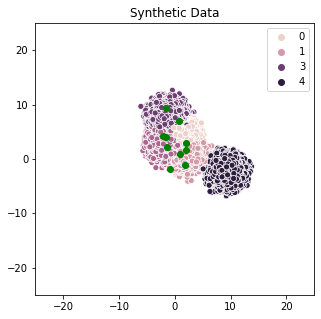

w1  0.02461177326277747  w2  0.9753882267372225
Time elapsed Batch Step:  0.42286157608032227
Time elapsed Assignment Step:  2.4135048389434814
indiv loss  0.7021420221206285
subgroup loss:  0.2918094431896231
iteration number:  18
old loss:  0.07021405395182345
temp loss:  0.07021420221206286
w1  0.37853957347196726  w2  0.6214604265280328
Time elapsed Batch Step:  0.411468505859375
Time elapsed Assignment Step:  2.3143346309661865
indiv loss  0.7021347257898078
subgroup loss:  0.29177071866057336
iteration number:  19
old loss:  0.07021405395182345
temp loss:  0.07021347257898079


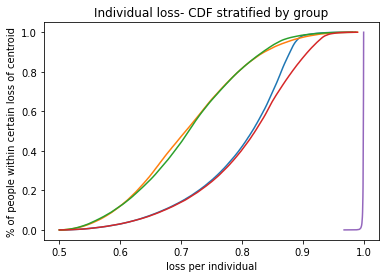

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.080569047403298, 1.7075460701204916), 4: (1.961250895229213, 3.0030577848568702), 5: (-1.420437022162725, 2.1068679686094915), 6: (1.7662919532062722, -1.12529033844204), 7: (-0.8658250640862901, -1.9127422758551988), 8: (0.9127881870223222, 0.8495082207136181), 9: (0.8246172860587468, 6.9024434503575165)}


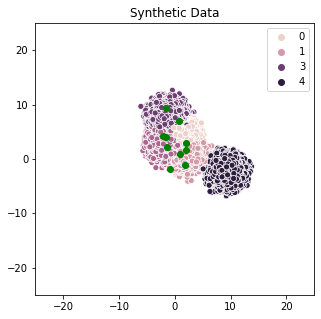

w1  0.24556053529052885  w2  0.7544394647094712
Time elapsed Batch Step:  0.42450737953186035
Time elapsed Assignment Step:  2.307156562805176
indiv loss  0.7021271438716179
subgroup loss:  0.2917292399571064
iteration number:  20
old loss:  0.07021347257898079
temp loss:  0.0702127143871618


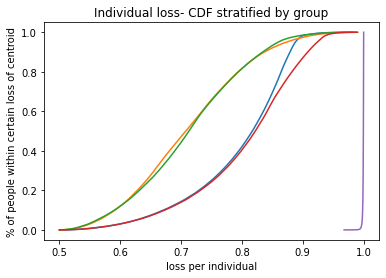

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.080117274030185, 1.708134134582589), 4: (1.961245442117382, 3.003637796465665), 5: (-1.4223600416705908, 2.1069996972800924), 6: (1.7662018146179315, -1.1253530697309577), 7: (-0.8673033670182698, -1.914013136884496), 8: (0.9122924847650077, 0.8494444617338467), 9: (0.8246172860587468, 6.9024434503575165)}


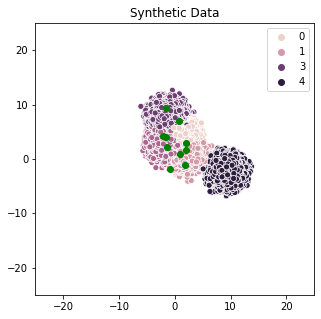

w1  0.34034608041393904  w2  0.6596539195860609
Time elapsed Batch Step:  0.41924118995666504
Time elapsed Assignment Step:  2.3230655193328857
indiv loss  0.7021188589618192
subgroup loss:  0.29168656767594037
iteration number:  21
old loss:  0.0702127143871618
temp loss:  0.07021188589618192


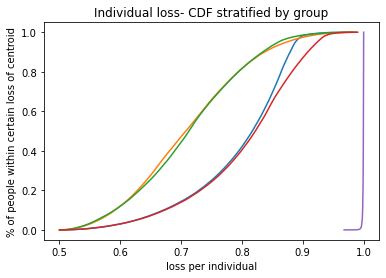

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.079774775056903, 1.708566270497946), 4: (1.9610409553967758, 3.0040098311920045), 5: (-1.4237633667632157, 2.1070145150162207), 6: (1.7661190682197654, -1.125421461017046), 7: (-0.8683737734984008, -1.9149333392677002), 8: (0.9119048928236408, 0.8494678975743987), 9: (0.8246172860587468, 6.9024434503575165)}


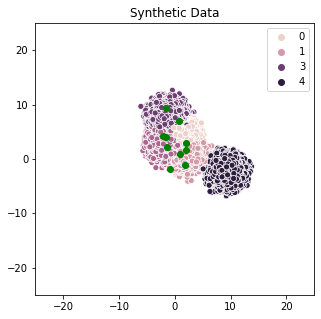

w1  0.009052079880679742  w2  0.9909479201193203
Time elapsed Batch Step:  0.4158341884613037
Time elapsed Assignment Step:  2.3497471809387207
indiv loss  0.7019375137781368
subgroup loss:  0.29064599439981786
iteration number:  22
old loss:  0.07021188589618192
temp loss:  0.07019375137781368


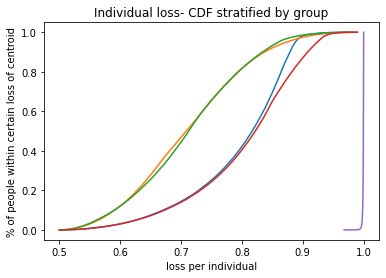

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0788853591558984, 1.7102491669574786), 4: (1.9610409553967758, 3.0040098311920045), 5: (-1.4237633667632157, 2.1070145150162207), 6: (1.7633041080728133, -1.1251646236109039), 7: (-0.8683737734984008, -1.9149333392677002), 8: (0.9185568311789032, 0.9051944773792777), 9: (0.8246172860587468, 6.9024434503575165)}


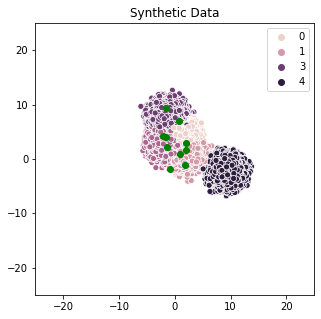

w1  0.2779037768359634  w2  0.7220962231640367
Time elapsed Batch Step:  0.42311739921569824
Time elapsed Assignment Step:  2.3603086471557617
indiv loss  0.7019282447190733
subgroup loss:  0.29059877997857353
iteration number:  23
old loss:  0.07019375137781368
temp loss:  0.07019282447190733


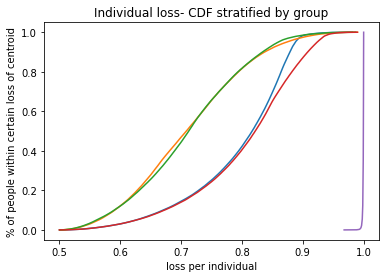

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.07848920561182, 1.7107736129573659), 4: (1.9609228119182225, 3.0045095244531708), 5: (-1.4254690419455847, 2.107131231244963), 6: (1.7632171093267957, -1.1252268388176596), 7: (-0.869684874209325, -1.9160604606194558), 8: (0.9181047942078175, 0.9052645057055406), 9: (0.8246172860587468, 6.9024434503575165)}


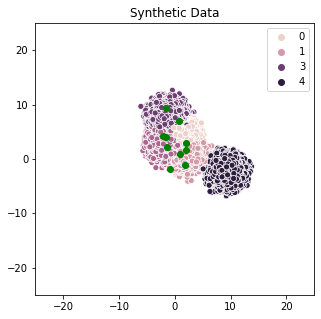

w1  0.15574768506570724  w2  0.8442523149342928
Time elapsed Batch Step:  0.44188714027404785
Time elapsed Assignment Step:  2.3574295043945312
indiv loss  0.7019166893466209
subgroup loss:  0.2905419766688121
iteration number:  24
old loss:  0.07019282447190733
temp loss:  0.0701916689346621


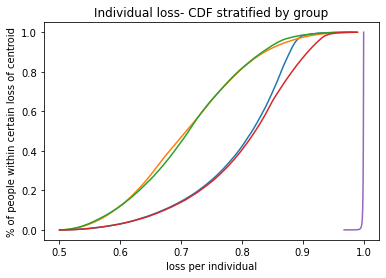

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.077881989602228, 1.7115240371464098), 4: (1.9608661109882206, 3.005499039019948), 5: (-1.4281140311015554, 2.1071896774110135), 6: (1.7631144840577555, -1.1252770400393977), 7: (-0.8717464989953743, -1.9178327892409748), 8: (0.9170898746939166, 0.9054484483311881), 9: (0.8246172860587468, 6.9024434503575165)}


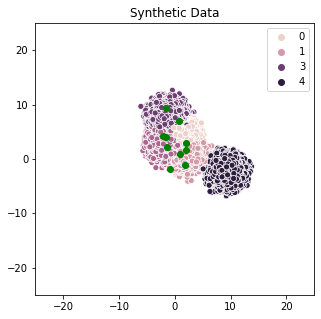

w1  0.222896165503645  w2  0.777103834496355
Time elapsed Batch Step:  0.42568302154541016
Time elapsed Assignment Step:  2.3126511573791504
indiv loss  0.7019135809107234
subgroup loss:  0.29052598638658456
iteration number:  25
old loss:  0.0701916689346621
temp loss:  0.07019135809107234


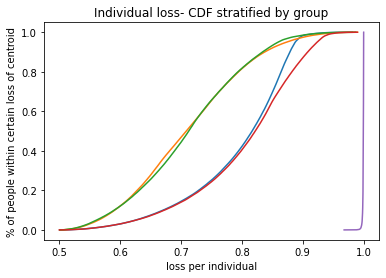

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.077797955586662, 1.7116156674635925), 4: (1.9608881565054614, 3.0056163411145964), 5: (-1.4284369774815364, 2.107211741387188), 6: (1.7630994212767477, -1.1252862803333568), 7: (-0.8719947057540002, -1.9180461665467503), 8: (0.9170127363250381, 0.9054506614627799), 9: (0.8246172860587468, 6.9024434503575165)}


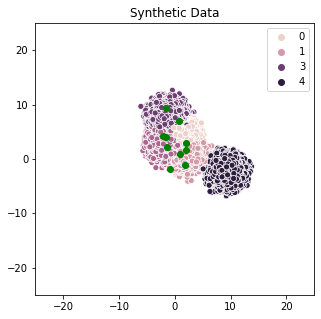

w1  0.390235572681017  w2  0.6097644273189831
Time elapsed Batch Step:  0.4383113384246826
Time elapsed Assignment Step:  2.3316009044647217
indiv loss  0.7019014209941312
subgroup loss:  0.2904584187726402
iteration number:  26
old loss:  0.07019135809107234
temp loss:  0.07019014209941313


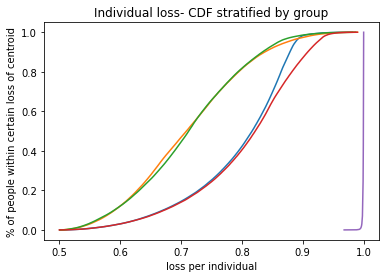

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0770931737567095, 1.7125214779543247), 4: (1.9605226867903123, 3.006385722417465), 5: (-1.4312573456450262, 2.1071076764044565), 6: (1.7629195920123784, -1.1254578718749422), 7: (-0.8741448066874055, -1.919894555957479), 8: (0.9163702915033163, 0.9057778954761632), 9: (0.8246172860587468, 6.9024434503575165)}


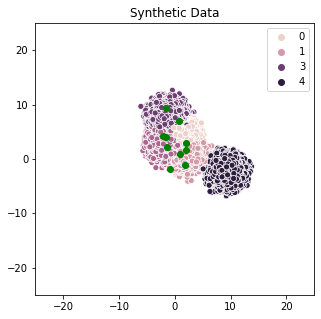

w1  0.16917832039922226  w2  0.8308216796007777
Time elapsed Batch Step:  0.4236137866973877
Time elapsed Assignment Step:  2.3193359375
indiv loss  0.7018866346824302
subgroup loss:  0.2903894198977409
iteration number:  27
old loss:  0.07019014209941313
temp loss:  0.07018866346824303


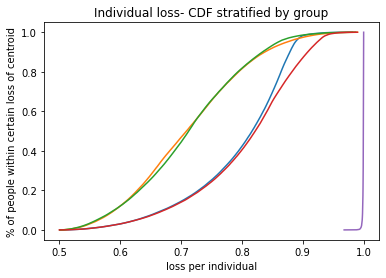

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.076495024353209, 1.7132378172209857), 4: (1.9603286464980085, 3.007272176969265), 5: (-1.433731081384274, 2.1072760956218985), 6: (1.762820700442248, -1.125508598301841), 7: (-0.8760458576548351, -1.921528843177608), 8: (0.9155148225496947, 0.9058428896117393), 9: (0.8246172860587468, 6.9024434503575165)}


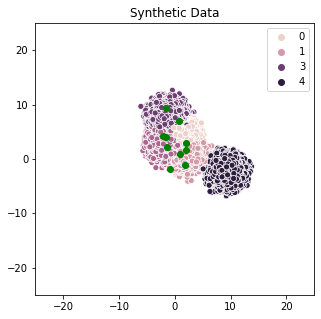

w1  0.12518848630283408  w2  0.8748115136971659
Time elapsed Batch Step:  0.4265255928039551
Time elapsed Assignment Step:  2.305487632751465
indiv loss  0.7018317090005386
subgroup loss:  0.29013337297877384
iteration number:  28
old loss:  0.07018866346824303
temp loss:  0.07018317090005387


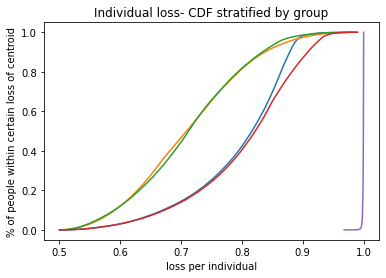

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0743661122390593, 1.7157210702717771), 4: (1.9607999907520195, 3.011538472387339), 5: (-1.4424723227658804, 2.1074689132714135), 6: (1.7625009274528944, -1.1256452889973059), 7: (-0.8828603528902853, -1.9273870987771333), 8: (0.9125247755804787, 0.9070006801602424), 9: (0.8246172860587468, 6.9024434503575165)}


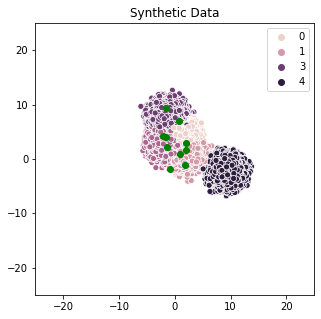

w1  0.23520136339994457  w2  0.7647986366000554
Time elapsed Batch Step:  0.42661595344543457
Time elapsed Assignment Step:  2.3521220684051514
indiv loss  0.7018213220272266
subgroup loss:  0.29007663953139873
iteration number:  29
old loss:  0.07018317090005387
temp loss:  0.07018213220272267


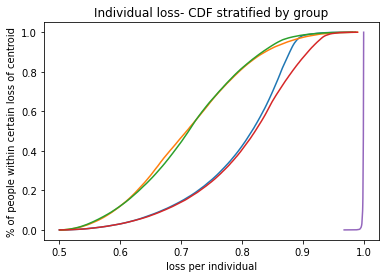

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0738358388968585, 1.716335886132473), 4: (1.960938556046696, 3.0122879365711595), 5: (-1.4444945333396857, 2.1076059059214165), 6: (1.7624062806006742, -1.1257105043208737), 7: (-0.8844138762379703, -1.9287226249659586), 8: (0.9119979860230815, 0.907013365784723), 9: (0.8246172860587468, 6.9024434503575165)}


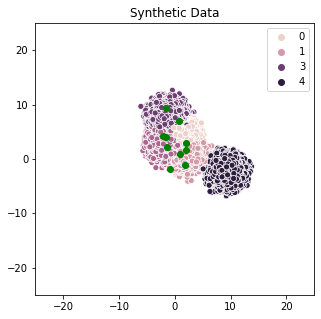

w1  0.1721868655314197  w2  0.8278131344685803
Time elapsed Batch Step:  0.44385194778442383
Time elapsed Assignment Step:  2.345860004425049
indiv loss  0.7018192101232743
subgroup loss:  0.29006672653890675
iteration number:  30
old loss:  0.07018213220272267
temp loss:  0.07018192101232744


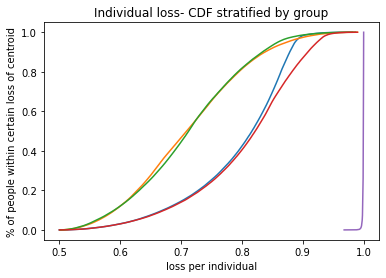

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.073764302521448, 1.7164249261081044), 4: (1.9609146699162636, 3.0124006333356146), 5: (-1.444802371767476, 2.1076267584257753), 6: (1.762394129447663, -1.1257171909275587), 7: (-0.8846503546151755, -1.9289259196678497), 8: (0.9118953199530504, 0.9070235886887995), 9: (0.8246172860587468, 6.9024434503575165)}


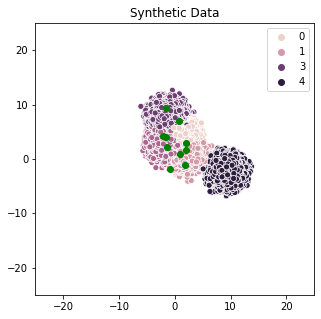

w1  0.22677427932148103  w2  0.7732257206785189
Time elapsed Batch Step:  0.4138453006744385
Time elapsed Assignment Step:  2.3473706245422363
indiv loss  0.7018081721243
subgroup loss:  0.2900073911184893
iteration number:  31
old loss:  0.07018192101232744
temp loss:  0.07018081721243001


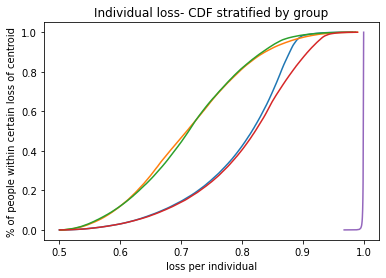

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0731935496961174, 1.7170131182086035), 4: (1.961057994335295, 3.0131764346492), 5: (-1.44688956280495, 2.107768139800231), 6: (1.762294891897611, -1.1257796100561281), 7: (-0.886253700938004, -1.9303042774550596), 8: (0.9113714030542411, 0.9070455332228915), 9: (0.8246172860587468, 6.9024434503575165)}


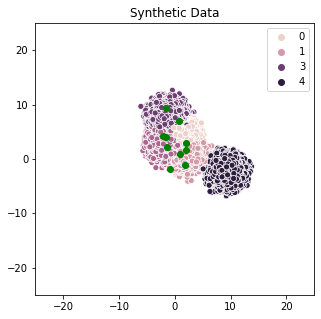

w1  0.04377109991543593  w2  0.9562289000845641
Time elapsed Batch Step:  0.42973875999450684
Time elapsed Assignment Step:  2.3177640438079834
indiv loss  0.7014146443271014
subgroup loss:  0.2891266294550775
iteration number:  32
old loss:  0.07018081721243001
temp loss:  0.07014146443271015


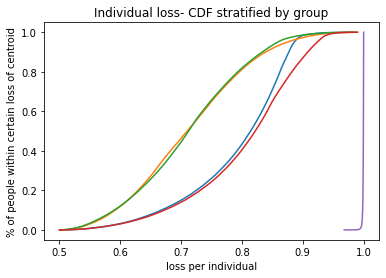

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0627292541201543, 1.7225993011439602), 4: (1.9509287196539378, 3.047413515131355), 5: (-1.44688956280495, 2.107768139800231), 6: (1.7608006109281698, -1.1258976613326257), 7: (-0.935537280052675, -1.9726721702097882), 8: (0.8967683151790603, 0.9065973709593551), 9: (0.8246172860587468, 6.9024434503575165)}


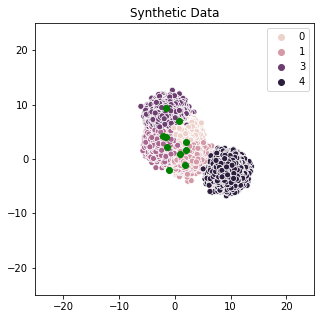

w1  0.0246398760732775  w2  0.9753601239267224
Time elapsed Batch Step:  0.42122459411621094
Time elapsed Assignment Step:  2.307853937149048
indiv loss  0.7014157443606295
subgroup loss:  0.28912602188363457
iteration number:  33
old loss:  0.07014146443271015
temp loss:  0.07014157443606295
w1  0.14665119435900226  w2  0.8533488056409977
Time elapsed Batch Step:  0.41651129722595215
Time elapsed Assignment Step:  2.3403124809265137
indiv loss  0.7013211373808665
subgroup loss:  0.28868297993931735
iteration number:  34
old loss:  0.07014146443271015
temp loss:  0.07013211373808666


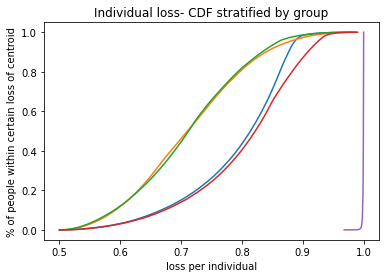

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.058823895796691, 1.7272870346509934), 4: (1.9507421464571022, 3.054649635537481), 5: (-1.463743415116454, 2.1081419705241595), 6: (1.7601551853596222, -1.1262052444956778), 7: (-0.9487155763018479, -1.9840012305622412), 8: (0.8903808154518986, 0.9075802236620987), 9: (0.8246172860587468, 6.9024434503575165)}


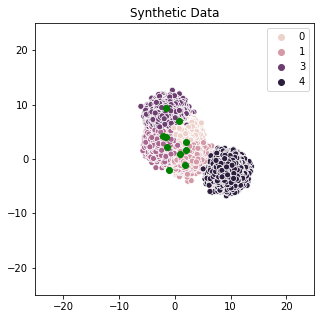

w1  0.2557585334141508  w2  0.7442414665858492
Time elapsed Batch Step:  0.41733717918395996
Time elapsed Assignment Step:  2.3428869247436523
indiv loss  0.7013117119217281
subgroup loss:  0.28863418253646367
iteration number:  35
old loss:  0.07013211373808666
temp loss:  0.07013117119217281


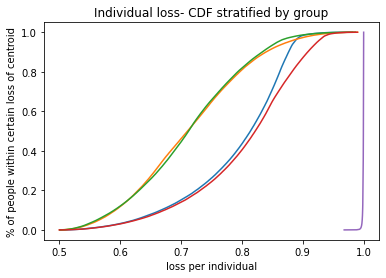

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.05831822843776, 1.7278745228828103), 4: (1.9506546934834392, 3.055326699360902), 5: (-1.4656392081027703, 2.1082691967187044), 6: (1.760065102437784, -1.1262740177649329), 7: (-0.9501516358349069, -1.985235775970246), 8: (0.8898217579823913, 0.907638314903455), 9: (0.8246172860587468, 6.9024434503575165)}


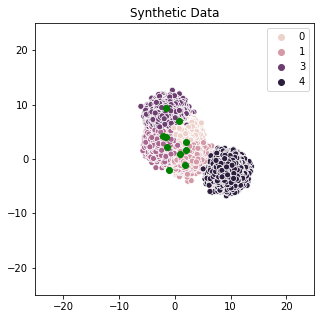

w1  0.041735431639182696  w2  0.9582645683608173
Time elapsed Batch Step:  0.43997955322265625
Time elapsed Assignment Step:  2.3369178771972656
indiv loss  0.7008609659792757
subgroup loss:  0.28732679301749964
iteration number:  36
old loss:  0.07013117119217281
temp loss:  0.07008609659792757


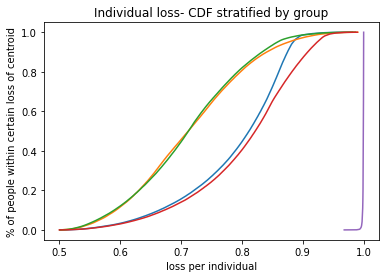

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0452590712261736, 1.7357760616749753), 4: (1.957054322710909, 3.1036703370999086), 5: (-1.4656392081027703, 2.1082691967187044), 6: (1.7580787848554151, -1.1264314174451595), 7: (-1.0147474382679889, -2.040767214211016), 8: (0.8692907808640018, 0.9067020438661206), 9: (0.8246172860587468, 6.9024434503575165)}


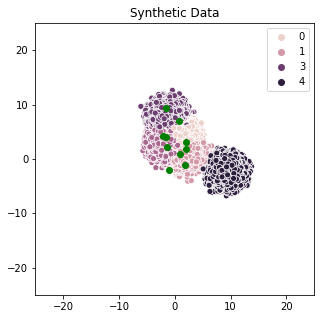

w1  0.391187432479989  w2  0.608812567520011
Time elapsed Batch Step:  0.41918039321899414
Time elapsed Assignment Step:  2.3692142963409424
indiv loss  0.7008596561944783
subgroup loss:  0.28732009249943924
iteration number:  37
old loss:  0.07008609659792757
temp loss:  0.07008596561944784


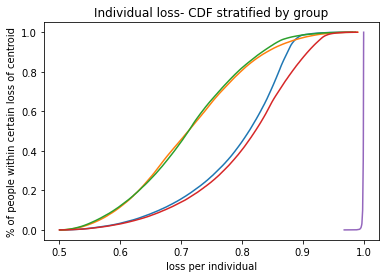

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0451592666421905, 1.7359015610503472), 4: (1.957001382620254, 3.103813080849366), 5: (-1.4660272852361764, 2.1082556486176465), 6: (1.7580530334076057, -1.1264571780900396), 7: (-1.0150326200981021, -2.0410123780852896), 8: (0.8691845358557347, 0.9067546160174688), 9: (0.8246172860587468, 6.9024434503575165)}


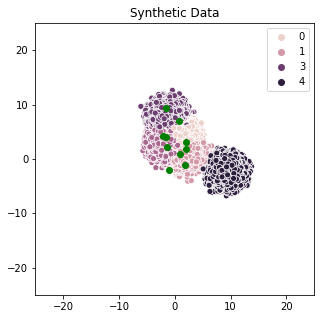

w1  0.04794964018722864  w2  0.9520503598127714
Time elapsed Batch Step:  0.42929792404174805
Time elapsed Assignment Step:  2.3573215007781982
indiv loss  0.7008343206092846
subgroup loss:  0.28722862704180174
iteration number:  38
old loss:  0.07008596561944784
temp loss:  0.07008343206092847


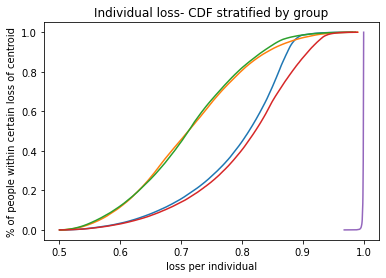

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.044319015327402, 1.736383981017601), 4: (1.95743031597621, 3.1064397339019334), 5: (-1.4706712666792718, 2.10781373650087), 6: (1.7579404412065187, -1.1264661879732143), 7: (-1.0186158868224455, -2.044092825224393), 8: (0.8679642217203182, 0.9066784722671558), 9: (0.8246172860587468, 6.9024434503575165)}


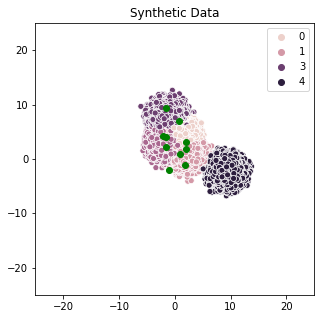

w1  0.3322523422615323  w2  0.6677476577384678
Time elapsed Batch Step:  0.4364509582519531
Time elapsed Assignment Step:  2.3733136653900146
indiv loss  0.7008253246952052
subgroup loss:  0.28718470235145743
iteration number:  39
old loss:  0.07008343206092847
temp loss:  0.07008253246952052


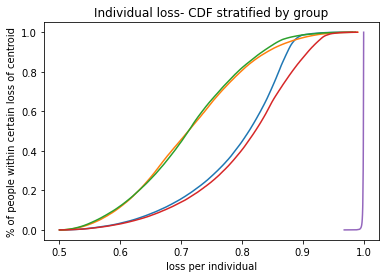

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0439140440113563, 1.7368567316742842), 4: (1.9572070581824217, 3.1069926388561124), 5: (-1.4721724033950931, 2.1078299962266978), 6: (1.7578526764918403, -1.1265428927459302), 7: (-1.0197187169492579, -2.0450409014270314), 8: (0.8674939542606981, 0.9067578537393319), 9: (0.8246172860587468, 6.9024434503575165)}


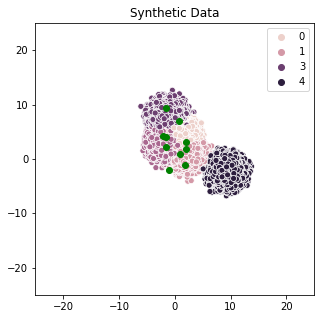

w1  0.12774133056619247  w2  0.8722586694338075
Time elapsed Batch Step:  0.41434216499328613
Time elapsed Assignment Step:  2.3333380222320557
indiv loss  0.7007853956230169
subgroup loss:  0.2870156861993327
iteration number:  40
old loss:  0.07008253246952052
temp loss:  0.07007853956230169


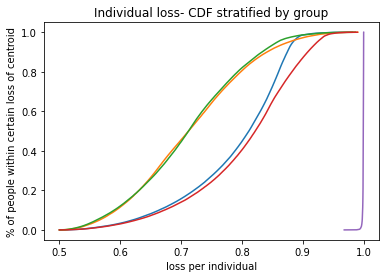

c  {0: (-1.5115294009373355, 9.405737363222864), 1: (-1.6372574281045003, 4.0128424834205205), 2: (-2.0113853467597202, 4.1462168575450296), 3: (2.0417843342358806, 1.739293089823479), 4: (1.9577115052921188, 3.112015250953913), 5: (-1.4805539424750471, 2.108012757055276), 6: (1.757540382059035, -1.1266832730581773), 7: (-1.0260392793367374, -2.0504745349859745), 8: (0.8641725504061545, 0.9077815486987887), 9: (0.8246172860587468, 6.9024434503575165)}


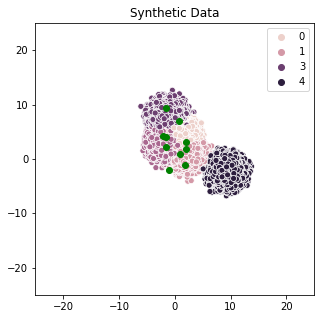

w1  0.32857035191567574  w2  0.6714296480843243
Time elapsed Batch Step:  0.4185333251953125
Time elapsed Assignment Step:  2.333381175994873
indiv loss  0.7008289145827591
subgroup loss:  0.28704302898570866
iteration number:  41
old loss:  0.07007853956230169
temp loss:  0.07008289145827591
w1  0.42908268294471036  w2  0.5709173170552897
Time elapsed Batch Step:  0.4179525375366211
Time elapsed Assignment Step:  2.322463035583496
indiv loss  0.7007984780839424
subgroup loss:  0.286880661750854
iteration number:  42
old loss:  0.07007853956230169
temp loss:  0.07007984780839424
w1  0.06702993278723529  w2  0.9329700672127648
Time elapsed Batch Step:  0.4111037254333496
Time elapsed Assignment Step:  2.3049654960632324
indiv loss  0.701055659204778
subgroup loss:  0.2873277353435638
iteration number:  43
old loss:  0.07007853956230169
temp loss:  0.0701055659204778
w1  0.15852945727191475  w2  0.8414705427280853
Time elapsed Batch Step:  0.41605663299560547
Time elapsed Assignment Step

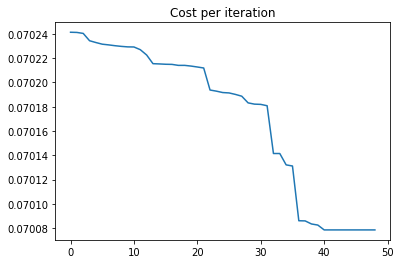

{0: (-1.5115294009373355, 9.405737363222864),
 1: (-1.6372574281045003, 4.0128424834205205),
 2: (-2.0113853467597202, 4.1462168575450296),
 3: (2.0417843342358806, 1.739293089823479),
 4: (1.9577115052921188, 3.112015250953913),
 5: (-1.4805539424750471, 2.108012757055276),
 6: (1.757540382059035, -1.1266832730581773),
 7: (-1.0260392793367374, -2.0504745349859745),
 8: (0.8641725504061545, 0.9077815486987887),
 9: (0.8246172860587468, 6.9024434503575165)}

In [16]:
df = assign_cluster(df, centroids)
groups = compute_groups(df)
compute_cdf_graph(groups)
clusters = compute_clusters(df)
cdf1, cdf2 = compute_cdf(groups)
#subgroup loss between max and min loss
subgroup_loss = compare_loss(groups[cdf1], groups[cdf2], 50)
loss = sum_loss(df, centroids, subgroup_loss)
update(.7, centroids,df, subgroup_loss, loss, groups, cdf1, cdf2)

In [17]:
centroids 

{0: (-1.5115294009373355, 9.405737363222864),
 1: (-1.6372574281045003, 4.0128424834205205),
 2: (-2.0113853467597202, 4.1462168575450296),
 3: (2.0417843342358806, 1.739293089823479),
 4: (1.9577115052921188, 3.112015250953913),
 5: (-1.4805539424750471, 2.108012757055276),
 6: (1.757540382059035, -1.1266832730581773),
 7: (-1.0260392793367374, -2.0504745349859745),
 8: (0.8641725504061545, 0.9077815486987887),
 9: (0.8246172860587468, 6.9024434503575165)}

In [18]:
df.head(30)

,x_coord,y_coord,group,dist_from_0,dist_from_1,dist_from_2,dist_from_3,dist_from_4,dist_from_5,dist_from_6,dist_from_7,dist_from_8,dist_from_9,min_centr,min_loss
0,-0.688103,7.193609,3,2.360412,3.317358,3.314997,6.092737,4.868193,5.147576,8.672620,9.265362,6.488510,1.540487,9,0.823536
1,0.194312,4.575750,0,5.122370,1.923968,2.237152,3.378342,2.301554,2.988766,5.913189,6.754438,3.742281,2.410557,1,0.872580
2,1.405993,4.042057,0,6.105817,3.053083,3.409678,2.382743,1.084795,3.484920,5.181352,6.578475,3.192283,2.918871,4,0.747400
3,-0.456957,8.746674,3,1.243579,4.876257,4.849286,7.433198,6.130902,6.717694,10.119096,10.827439,7.963035,2.245800,0,0.776186
4,9.563979,-2.428965,4,16.208857,12.932419,13.306214,8.606152,9.399690,11.953095,7.915571,10.609423,9.307436,12.784820,6,0.999635
5,-1.222979,8.719533,3,0.744404,4.720756,4.635360,7.699448,6.449666,6.615579,10.287771,10.786198,8.099675,2.737602,0,0.677958
6,-0.846731,7.283136,3,2.224274,3.361913,3.339237,6.244600,5.030641,5.213959,8.804141,9.350216,6.614843,1.714157,9,0.847375
7,-1.391837,6.850959,3,2.557581,2.844567,2.768919,6.151101,5.026951,4.742551,8.576991,8.923028,6.371064,2.217052,9,0.901770
8,1.981638,3.415283,0,6.934534,3.678325,4.050816,1.671693,0.295932,3.712824,4.548326,6.257800,2.754384,3.674096,4,0.573448
9,1.476222,4.437901,0,5.797073,3.151337,3.490083,2.751239,1.410224,3.774069,5.572386,6.972544,3.594300,2.549227,4,0.803801


In [19]:
df = assign_cluster(df, centroids)
df

Time elapsed Assignment Step:  2.33963942527771


,x_coord,y_coord,group,dist_from_0,dist_from_1,dist_from_2,dist_from_3,dist_from_4,dist_from_5,dist_from_6,dist_from_7,dist_from_8,dist_from_9,min_centr,min_loss
0,-0.688103,7.193609,3,2.360412,3.319363,3.322299,6.099331,4.864128,5.146967,8.672279,9.250258,6.474657,1.540487,9,0.823536
1,0.194312,4.575750,0,5.122370,1.916119,2.247131,3.385062,2.291746,2.982432,5.912819,6.737663,3.728633,2.410557,1,0.871705
2,1.405993,4.042057,0,6.105817,3.043390,3.418965,2.388923,1.081375,3.474576,5.180682,6.560009,3.180763,2.918871,4,0.746754
3,-0.456957,8.746674,3,1.243579,4.878757,4.855971,7.439562,6.130253,6.717110,10.118655,10.812135,7.949441,2.245800,0,0.776186
4,9.563979,-2.428965,4,16.208857,12.921477,13.312478,8.599871,9.410513,11.940095,7.914317,10.596780,9.317752,12.784820,6,0.999635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,1.954802,4.651530,0,5.883702,3.648399,3.998248,2.913535,1.539517,4.274477,5.781579,7.335004,3.899375,2.518716,4,0.823395
799996,-0.864044,9.435572,3,0.648172,5.477577,5.412363,8.226576,6.924570,7.353449,10.882736,11.487189,8.701146,3.044391,0,0.656598
799997,9.480259,-2.934193,4,16.525535,13.109557,13.497781,8.784781,9.651185,12.064960,7.931424,10.543399,9.433860,13.102655,6,0.999641
799998,-0.706814,8.844517,3,0.981089,4.920448,4.876057,7.618333,6.321493,6.780794,10.271216,10.899667,8.090721,2.473243,0,0.727324
